In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Importing the required packages 

import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from os import system
from nltk.corpus import stopwords as stw
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
# from NB_MP2 import Multinomial_NB
# from utils_MP2 import double_plot, my_tokenizer, pichart_categories, eval_acc, load_imdb

In [ ]:
# Defining custom functions

# Pre process the dataset

def my_tokenizer(t):

    #no_html = BeautifulSoup(t, features="html.parser").get_text()

    #clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)

    # remove punctuations
    t1 = re.sub(r"[-,.;:@#?!_%&$`]+", ' ', t)

    # print(f"remove punctuation {t1}")

    # # # remove html markup
    text = re.sub(r"(<.*>)", "", t1)
    # # print(f"remove html {text}")

    # remove non-ascii and digits
    text = re.sub("(\\W|\\d\\br)", " ", text)
    # print(f"remove ascii and disgits {text}")

    # replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    # print(f"remove mspaces {text}")

    return text


# Evaluate Accuracy 
def eval_acc(y, y_pred):
    accuracy = np.sum(y_pred == y) / y.shape[0]
    return accuracy

# Plotting two line graphs on same plot
def double_plot(x_list, y_list, y1_list, filename, x_label, y_label, plot_name, legend):
    fig = plt.figure()
    sb = fig.add_subplot(1, 1, 1)
    plt.plot(x_list, y_list, linewidth=2, color='r',label=legend[0])
    plt.plot(x_list, y1_list, linewidth=2,color='b', label=legend[1])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(x_list)
    sb.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    header = plot_name + " Metrics: " + filename
    plt.title(header)
    plt.legend(loc="upper right")
    # plt.savefig(header)
    # plt.close(fig)

# Plotting Pi Chart for News Group dataset
def pichart_categories(d_train):
    fig = plt.figure(figsize=(10, 10))

    targets, sizes = np.unique(d_train.target, return_counts=True)
    target_names = [d_train.target_names[i] for i in targets]

    patches, _, _ = plt.pie(sizes, autopct='%1.1f%%', wedgeprops={'alpha': 0.8})

    plt.legend(patches, target_names, loc=(1, 0.0))

    plt.axis('equal')
    plt.savefig("20newsgroup_pichart")
    plt.close(fig)

# Loading the IMDB dataset 
def load_imdb():
    # Loading the IMDB reviews dataset after downloading the tarfile from website
    imdb_tar=tarfile.open("aclImdb_v1.tar","r:")
    imdb_tar.extractall()
    imdb_tar.close()
    # Creating data frame
    imdb_train = create_data_frame('aclImdb/train')
    imdb_test = create_data_frame('aclImdb/test')
    system("mkdir 'csv'")
    imdb_train.to_csv('csv/imdb_train.csv', index=False)
    imdb_test.to_csv('csv/imdb_test.csv', index=False)

# Creating a dataframe out of the IMDB dataset to enable easy manipulation of data    

def create_data_frame(folder: str) -> pd.DataFrame:
    '''
    folder - the root folder of train or test dataset
    Returns: a DataFrame with the combined data from the input folder
    '''
    pos_folder = f'{folder}/pos'  # positive reviews
    neg_folder = f'{folder}/neg'  # negative reviews

    def get_files(fld: str) -> list:
        '''
        fld - positive or negative reviews folder
        Returns: a list with all files in input folder
        '''
        return [join(fld, f) for f in listdir(fld) if isfile(join(fld, f))]

    def append_files_data(data_list: list, files: list, label: int) -> None:
        '''
        Appends to 'data_list' tuples of form (file content, label)
        for each file in 'files' input list
        '''
        for file_path in files:
            with open(file_path, 'r') as f:
                text = f.read()
                data_list.append((text, label))

    pos_files = get_files(pos_folder)
    neg_files = get_files(neg_folder)

    data_list = []
    append_files_data(data_list, pos_files, 1)
    append_files_data(data_list, neg_files, 0)
    shuffle(data_list)

    text, label = tuple(zip(*data_list))

    # replacing line breaks with spaces
    text = list(map(lambda txt: re.sub('(<br\\s*/?>)+', ' ', txt), text))

    return pd.DataFrame({'text': text, 'label': label})

In [ ]:
# Implementing the Multinomial Naive Bayes function


class Multinomial_NB():

    def __init__(self, alpha=1):
        self.alpha = alpha

    def fit(self, x_t, y_t):
        X_train = x_t
        y_train = np.array(y_t)
        m, n = X_train.shape
        self.classes = np.unique(y_train)
        n_classes = len(self.classes)

        # init: Prior & Likelihood
        self.priors = np.zeros(n_classes)
        self.likelihoods = np.zeros((n_classes, n))

        # Get Prior and Likelihood
        for i, c in enumerate(self.classes):
            X_train_c = X_train[c == y_train]
            self.priors[i] = X_train_c.shape[0] / m
            self.likelihoods[i, :] = ((X_train_c.sum(axis=0)) + self.alpha) / (np.sum(X_train_c.sum(axis=0) + self.alpha))

    def predict(self, X_test):
        return [self._predict(x_test) for x_test in X_test]

    def _predict(self, x_te):
        # Calculate posterior for each class
        x_test = x_te
        posteriors = []
        for i, c in enumerate(self.classes):
            prior_c = np.log(self.priors[i])
            likelihoods_c = self.calc_likelihood(self.likelihoods[i, :], x_test)
            posteriors_c = np.sum(likelihoods_c) + prior_c
            posteriors.append(posteriors_c)
        return self.classes[np.argmax(posteriors)]

    def calc_likelihood(self, cls_likeli, x_test):
        return sparse.csr_matrix(np.log(cls_likeli)).multiply(x_test)

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.sum(y_pred == y_test) / len(y_test)

In [ ]:
# Function to Load the dataset 

def load_data(name, remove_headers=False):
    if name == "20newsgroup":
    # Loading the dataset -Found twenty news group one directly on scikit learn
        if remove_headers:
            data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=123,remove=('headers', 'footers','quotes'))
            data_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=123,remove=('headers', 'footers', 'quotes'))
        else:
            data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=21)
            data_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=21)

    elif name == "IMDB_review":
        # Loading the IMDB tarfile. Run this code when downloading the dataset first time.
        # load_imdb()
        # Reading csv is much faster
        data_train = pd.read_csv('csv/imdb_train.csv')
        data_test = pd.read_csv('csv/imdb_test.csv')

    else:
        print(" Incorrect dataset name. Please select either 20 news group or IMDB Review dataset")
        data_train, data_test = [],[]

    return data_train, data_test


In [ ]:
# Function to do Feature Engineering

def feature_engineering(data_train, data_test, d_name, countvec=False, countvec_bigram=False, tfidfvec=False):
    if countvec:
    # Converting into text- used count vectorizer but its not going to be good
        if d_name =="20newsgroup":
            vector_format = CountVectorizer(stop_words=stw.words('english'), analyzer='word', lowercase=True,
                                            preprocessor=my_tokenizer, max_features = 20000) # Remove Stopwords
            x_train_whole = vector_format.fit_transform(data_train.data)
            y_train_whole = data_train.target
            x_test = vector_format.transform(data_test.data)
            y_test = data_test.target
        else:
            # IMDB datset
            vector_format = CountVectorizer(stop_words=stw.words('english'), analyzer='word', lowercase=True,
                                            preprocessor=my_tokenizer, max_features = 20000)
            x_train_whole = vector_format.fit_transform(data_train['text'].values)
            y_train_whole = data_train['label'].values
            x_test = vector_format.transform(data_test['text'].values)
            y_test = data_test['label'].values

    elif countvec_bigram:
        if d_name == "20newsgroup":
            vector_format = CountVectorizer(stop_words=stw.words('english'), analyzer='word', lowercase=True,
                                            preprocessor=my_tokenizer, ngram_range=(1,2), max_features = 20000)
            x_train_whole = vector_format.fit_transform(data_train.data)
            y_train_whole = data_train.target
            x_test = vector_format.transform(data_test.data)
            y_test = data_test.target
        else:
            vector_format = CountVectorizer(stop_words=stw.words('english'), analyzer='word', lowercase=True,
                                            preprocessor=my_tokenizer, ngram_range=(1, 2), max_features = 20000)
            x_train_whole = vector_format.fit_transform(data_train['text'].values)
            y_train_whole = data_train['label'].values
            x_test = vector_format.transform(data_test['text'].values)
            y_test = data_test['label'].values

    elif tfidfvec:
        # Converting into TF-IDf Vector
        if d_name == "20newsgroup":
            tfd_ifd = TfidfVectorizer(stop_words=stw.words('english'), analyzer='word', lowercase=True,
                                      preprocessor=my_tokenizer, max_features = 20000)
            x_train_whole = tfd_ifd.fit_transform(data_train.data)
            y_train_whole = data_train.target
            x_test = tfd_ifd.transform(data_test.data)
            y_test = data_test.target

        else:
            # IMDB datset
            tfd_ifd = TfidfVectorizer(stop_words=stw.words('english'), analyzer='word', lowercase=True,
                                      preprocessor=my_tokenizer, max_features = 200000)
            x_train_whole = tfd_ifd.fit_transform(data_train['text'].values)
            y_train_whole = data_train['label'].values
            x_test = tfd_ifd.transform(data_test['text'].values)
            y_test = data_test['label'].values

    else:
        print("Feature Engineering method not supported")
        x_train_whole, y_train_whole, x_test, y_test = [], [], [], []

    return x_train_whole, y_train_whole, x_test, y_test


In [ ]:
# Function to split training data into Validation and train

def val_train_split(x_tr,y_tr, train_percent):
    l = x_tr.shape[0]
    x, y = sklearn.utils.shuffle(x_tr, y_tr, random_state=1234)
    split = round( train_percent*l)
    if str(type(x)) == "<class 'scipy.sparse.csr.csr_matrix'>":
        indices = range(0, split)
        mask = np.zeros(x.shape[0], dtype=bool)
        mask[indices] = True
        x_t = x[mask]
        y_t = y[mask]
        x_v = x[split:]
        y_v = y[split:]

    elif str(type(x)) == "<type 'numpy.ndarray'>":
        x_t = np.concatenate((x[:split], x[split:]))
        y_t = np.concatenate((y[:split], y[split:]))
        x_v = x[split:]
        y_v = y[split]
    else:
        print(" Format not recognised")
        x_t, y_t, x_v, y_v = [], [], [], []
    return x_t, y_t,x_v, y_v


In [ ]:
# Function to train and predict the Multinomial Naive Bayes class for the dataset.

def Mult_NB(x_train, y_train, x_test, y_test, a=0.01):
    clf_NB = Multinomial_NB(alpha=a)
    clf_NB.fit(x_train, y_train)
    pred_test = clf_NB.predict(x_test)
    accuracy_NB_test = eval_acc(y_test, pred_test)
    pred_train = clf_NB.predict(x_train)
    accuracy_NB_train = eval_acc(y_train, pred_train)
    return accuracy_NB_test, accuracy_NB_train


In [ ]:
#  Function to train and predict the scikit learn implementation of the Logistic Regression method.

def LR (x_train, y_train, x_test, y_test, norm='l2', solv='liblinear', reg=10, mi=100):
    # Fitting Plain vanilla Logistic regression Model
    clf_lg = LogisticRegression(solver=solv, C=reg, penalty=norm, max_iter=mi, tol=0.01)
    clf_lg.fit(x_train, y_train)
    pred_test = clf_lg.predict(x_test)
    # accuracy_lg_test = metrics.accuracy_score(y_test, pred_test)
    accuracy_lg_test = eval_acc(y_test, pred_test)
    pred_train = clf_lg.predict(x_train)
    #accuracy_lg_train = metrics.accuracy_score(y_train, pred_train)
    accuracy_lg_train = eval_acc(y_train, pred_train)
    return accuracy_lg_test, accuracy_lg_train,


In [ ]:
# Implementing K-Fold Cross Validation split 

def cross_validation_split(x_tr, y_tr, L, i):
    l = x_tr.shape[0]
    x, y = sklearn.utils.shuffle(x_tr, y_tr, random_state=1234)
    ratio = l/L
    start = round(ratio * i)
    end = round(ratio * (i + 1))
    if str(type(x)) == "<class 'scipy.sparse.csr.csr_matrix'>":
        indices = range(start, end)
        mask = np.ones(x.shape[0], dtype=bool)
        mask[indices] = False
        x_t = x[mask]
        y_t = y[mask]
        x_v = x[start:end]
        y_v = y[start:end]

    elif str(type(x)) == "<type 'numpy.ndarray'>":
        x_t = np.concatenate((x[:start], x[end:]))
        y_t = np.concatenate((y[:start], y[end:]))
        x_v = x[start:end]
        y_v = y[start:end]
    else:
        print(" Format not recognised")
        x_t, y_t, x_v, y_v = [], [], [], []
    return x_t, y_t,x_v, y_v


def kfoldCV(x, y, method, L,alpha=0.05 ,max_iter=100, solv='saga', reg=10):
    val_acc_train, val_acc_test = [], []
    for i in range(0, L):
        x_t, y_t, x_v, y_v = cross_validation_split(x, y, L, i)
        if method == "NB":
            a_test, a_train = Mult_NB(x_t, y_t, x_v, y_v, a=alpha)
        elif method == "LR":
            a_test, a_train = LR(x_t, y_t, x_v, y_v, solv=solv, reg=reg, mi=max_iter )
        else:
            print("Method not correct")
            a_test, a_train = 0,0
        val_acc_train.append(a_train)
        val_acc_test.append(a_test)

    return np.mean(val_acc_test), np.mean(val_acc_train)


In [ ]:
name = "20newsgroup" 
d_train, d_test = load_data(name, remove_headers=True)

In [ ]:
pichart_categories(d_train=d_train)

In [ ]:
# Count Vector without Stopwords
x_train_w, y_train_w, x_test, y_test = feature_engineering(d_train, d_test, name, countvec=True)

In [ ]:
# Count Vector with Bigram w/o Stopwords
x_train_w, y_train_w, x_test, y_test = feature_engineering(d_train, d_test, d_name=name, countvec_bigram=True)


In [ ]:
# TF-IDF Vector w/o Stopwords
x_train_w, y_train_w, x_test, y_test = feature_engineering(d_train, d_test, name, tfidfvec=True)

In [ ]:
# Spltting into train and validate
x_train, y_train, x_val, y_val = val_train_split(x_train_w, y_train_w, train_percent=0.7)

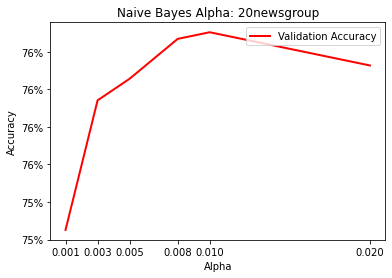

In [ ]:
# Hyper Parameter tuning using Cross Validation For Naive Bayes Classifier 
alpha_list = [0.001, 0.003, 0.005, 0.008, 0.01, 0.02]
acc_list_test, acc_list_train = [], []
for a in alpha_list:
    accuracy_NB_test, accuracy_NB_train = kfoldCV(x_train_w, y_train_w, method='NB', L=5, alpha=a)
    acc_list_test.append(accuracy_NB_test)
    acc_list_train.append(accuracy_NB_train)
fig = plt.figure()
sb = fig.add_subplot(1, 1, 1)
plt.plot(alpha_list, acc_list_test, linewidth=2,color='r', label="Validation Accuracy")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.xticks(alpha_list)
sb.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
header = "Naive Bayes" + " Alpha: " + name
plt.title(header)
plt.legend(loc="upper right")
plt.show()
plt.close(fig)


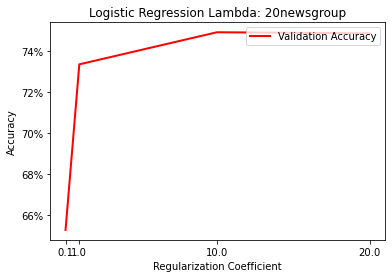

In [ ]:
# Hyper Parameter tuning using Cross Validation For Logistic Regression Classifier 

C_list = [0.1, 1, 10, 20]
acc_list_test, acc_list_train = [], []
for r in C_list:
    accuracy_NB_test, accuracy_NB_train = kfoldCV(x_train_w, y_train_w,solv='saga', method='LR', L=5, reg=r)
    acc_list_test.append(accuracy_NB_test)
    acc_list_train.append(accuracy_NB_train)
fig = plt.figure()
sb = fig.add_subplot(1, 1, 1)
plt.plot(C_list, acc_list_test, linewidth=2,color='r', label="Validation Accuracy")
plt.xlabel("Regularization Coefficient")
plt.ylabel("Accuracy")
plt.xticks(C_list)
sb.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
header = "Logistic Regression" + " Lambda: " + name
plt.title(header)
plt.legend(loc="upper right")
plt.show()
plt.close(fig)

    

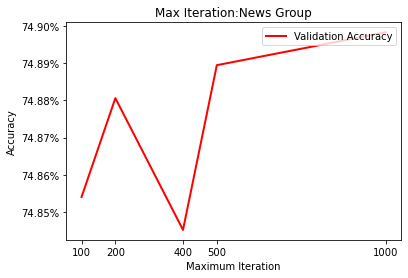

In [ ]:
# Exploring the effect of changing regularisation coefficient for Logistic Regression

iter_list = [100, 200, 400, 500, 1000]
acc_list_test, acc_list_train = [], []
for n in iter_list:
    accuracy_NB_test, accuracy_NB_train = kfoldCV(x_train_w, y_train_w, solv='saga', method='LR', L=5, max_iter=n)
    acc_list_test.append(accuracy_NB_test)
    acc_list_train.append(accuracy_NB_train)
fig = plt.figure()
sb = fig.add_subplot(1, 1, 1)
plt.plot(iter_list, acc_list_test, linewidth=2, color='r', label="Validation Accuracy")
plt.xlabel("Maximum Iteration")
plt.ylabel("Accuracy")
plt.title("Max Iteration:News Group")
plt.xticks(iter_list)
sb.yaxis.set_major_formatter(FuncFormatter('{0:.2%}'.format))
plt.legend(loc="upper right")
plt.show()
plt.close(fig)

C:\Users\satya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\satya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

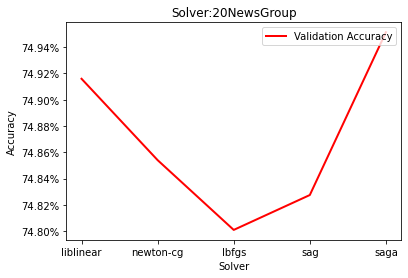

In [ ]:
reg_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag','saga']
acc_list_test, acc_list_train = [], []
for r in reg_list:
    accuracy_NB_test, accuracy_NB_train = kfoldCV(x_train_w, y_train_w, solv=r, method='LR', L=5, reg=10)
    acc_list_test.append(accuracy_NB_test)
    acc_list_train.append(accuracy_NB_train)
fig = plt.figure()
sb = fig.add_subplot(1, 1, 1)
plt.plot(reg_list, acc_list_test, linewidth=2, color='r', label="Validation Accuracy")
plt.xlabel("Solver")
plt.ylabel("Accuracy")
plt.title("Solver:20NewsGroup")
plt.xticks(reg_list)
sb.yaxis.set_major_formatter(FuncFormatter('{0:.2%}'.format))
plt.legend(loc="upper right")
plt.show()
plt.close(fig)

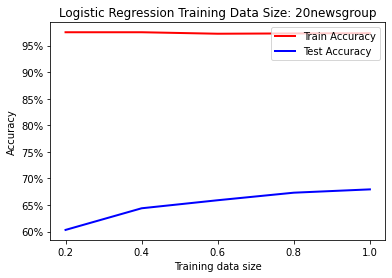

In [ ]:
data_size_list = [ 0.2, 0.4, 0.6, 0.8,1]
acc_list_test, acc_list_train = [], []
for p in data_size_list:
    x_train, y_train, x_val, y_val = val_train_split(x_train_w, y_train_w, train_percent=p)
    a_test, a_train = LR(x_train, y_train, x_test, y_test, solv='saga', norm='l2', mi=100, reg=10)
    acc_list_test.append(a_test)
    acc_list_train.append(a_train)
fig = plt.figure()
sb = fig.add_subplot(1, 1, 1)
plt.plot(data_size_list, acc_list_train, linewidth=2, color='r',label="Train Accuracy")
plt.plot(data_size_list, acc_list_test, linewidth=2,color='b', label="Test Accuracy")
plt.xlabel("Training data size")
plt.ylabel("Accuracy")
plt.xticks(data_size_list)
sb.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
header = "Logistic Regression" + " Training Data Size: " + name
plt.title(header)
plt.legend(loc="upper right")
plt.show()
plt.close(fig)


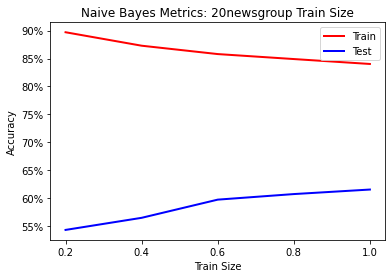

In [ ]:
data_size_list = [0.2, 0.4, 0.6, 0.8, 1]
acc_list_test, acc_list_train = [], []
for p in data_size_list:
    x_train, y_train, x_val, y_val = val_train_split(x_train_w, y_train_w, train_percent=p)
    a_test, a_train = Mult_NB(x_train,y_train,x_test, y_test, a=0.05)
    acc_list_test.append(a_test)
    acc_list_train.append(a_train)
double_plot(data_size_list, acc_list_train, acc_list_test, name + " Train Size",
                  x_label="Train Size", y_label="Accuracy", plot_name="Naive Bayes", legend=["Train", "Test"])


In [ ]:
# Reporting best combination on Test data
Accuracy_Test_NB, _ = Mult_NB(x_train_w,y_train_w,x_test, y_test, a=0.01)
print(f"NB Accuracy Test :{Accuracy_Test_NB}")

Accuracy_Test_LR, _ = LR(x_train_w, y_train_w, x_test, y_test, solv='liblinear', norm='l2', mi=1000, reg=10)
print(f"LR Accuracy Test :{Accuracy_Test_LR}")

NB Accuracy Test :0.6756505576208178
LR Accuracy Test :0.6672862453531598


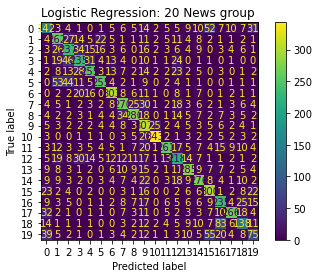

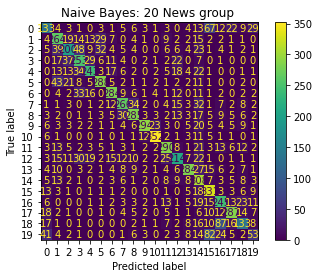

In [ ]:
# Plotting the Confusion Matrix and Generating the classification report
clf_lg = LogisticRegression(solver='saga', penalty='l2', max_iter=1000, C=10, tol=0.001)
clf_lg.fit(x_train, y_train)
plot_confusion_matrix(clf_lg, x_test, y_test)  
plt.title('Logistic Regression: 20 News group ')

clf_NB = MultinomialNB(alpha=0.01)
clf_NB.fit(x_train, y_train)
plot_confusion_matrix(clf_NB, x_test, y_test)  
plt.title('Naive Bayes: 20 News group ')
plt.show()


In [ ]:
def classifier_svc(x_train, y_train, x_test, y_test, k,c):
    clf_svc = SVC(kernel=k, C=c)
    clf_svc.fit(x_train, y_train)
    pred_test = clf_svc.predict(x_test)
    accuracy_lg_test = metrics.accuracy_score(y_test, pred_test)
    return accuracy_lg_test

In [ ]:
# Running Support Vector Classifier 

Accuracy_Test_svc = classifier_svc(x_train_w, y_train_w, x_test, y_test,k="linear", c=0.5)
print(f"svc Accuracy Test :{Accuracy_Test_svc}")



svc Accuracy Test :0.6481678173127987


In [ ]:
# Bagging reduces the Variance but increases the bias

from sklearn.ensemble import BaggingClassifier
    
clf_lr = LogisticRegression(solver='saga', C=10, penalty='l2', max_iter=100, tol=0.001)
bag_lr = BaggingClassifier(clf_lr, random_state=2, max_samples=0.5, max_features=0.5)
bag_lr.fit(x_train_w, y_train_w)
acc_blr = bag_lr.score(x_test, y_test)
print(acc_blr)
    
clf_NB = MultinomialNB(alpha=0.05)
bag_lr = BaggingClassifier(clf_NB, random_state=2, max_samples=0.5, max_features=0.5)
bag_lr.fit(x_train_w, y_train_w)
acc_blr = bag_lr.score(x_test, y_test)
print(acc_blr)

0.6610462028677642
0.6752522570366436
